
   **Purpose**: This Notebook abstracts and summarizes the process of analysing and obtaining scores and statistics from big simulations of CO$_2$MPAS run on a cluster located in Petten (Higgs).
   
   http://higgs.jrc.nl/ganglia/?c=HIGGS%20Cluster&m=load_one&r=hour&s=by%20name&hc=4&mc=2
   
   http://www.cc.cec/wikis/display/iethpc/HPC

   **Author:** Victor Valverde Morales and Ignacio Iker Prado Rujas.

   **Date**: June-July 2017.
   
```
Copyright 2017 European Commission (JRC)
Licensed under the EUPL (the 'Licence')
You may not use this work except in compliance with the Licence.
You may obtain a copy of the Licence at: http://ec.europa.eu/idabc/eupl
```


# Full workflow of the simulation:

## General requirements in Petten:

Before installing and launching anything in Petten, we need to set up the cluster. This means:

**(1) Set up passphrase for `ssh`:** Use `ssh-keygen -t rsa` and then `scp` the generated public key to the cluster in `~/.ssh`

**(2) Modify `~/.bashrc` file:** Add `umask 0002` to `~/.bashrc` file.

**(3) Set up proxy enrironment variables:** This is only needed if you want to connect to the internet (for instance to update a Python library). Create and fill `~/bin/set_proxy.sh` file. An example can be found in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\useful_scripts\set_proxy.sh`. Afterwards, type `source ~/bin/set_proxy.sh prompt` and introduce your net user and password.

**(4) Load `anaconda` module, create and activate environment:** First load `anaconda` using `module load anaconda/3-4.0.0` (or the corresponding one). Then create a `conda` environment using `conda create --name py36.cenv python=3.6` (choose your own environment name and Python version). Lastly, activate it with `source activate py36.cenv`. In order to avoid having to activate this environment every time you log in into the cluster, you can add to your `~/.bashrc` file `module load anaconda/3-4.0.0` and `source activate py36.cenv`. Then, those two lines will always be executed when you log in, making sure Python is there.

**(5) Solving IPv6 problem:** In order to be able to launch Jupyter Notebook correctly, we faced a problem related to IPv6. In case it happens to you, this is how we solved it: First run `jupyter notebook --generate-config` in order to generate the configuration files from Jupyter in Petten. Then edit the following file (using vim, nano...): `.jupyter/jupyter_notebook_config.py`. Find the line that says `c.NotebookApp.ip` and type `c.NotebookApp.ip = '127.0.0.1'`. Then Jupyter notebook should work correctly.

## Requirements for each run:

Before any launch, this four things need to be checked:

**(1) CO$_2$MPAS version:** Install the correct CO$_2$MPAS version in Petten. Since the git version installed there is quite outdated, usually we download the sources from the GitHub repository, then we `scp` them to Petten (see the **NOTE**). Afterwards make sure that there is **no other version already installed!** Lastly, we `pip` install it using `pip install -e co2mpas-source-folder`

**(2) Input files:** Before launching it, `scp` the input cars so they are reachable by CO$_2$MPAS. In the last launches we have been using the cars located in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\Real_cars_input`

**(3) Parameter combinations:** For generating the `yaml` files, we read the parameter combination from an Excel file, by rows. One `yaml` file will be generated for every row. The current Excel used for this can be found in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\Parameter_combination_Launch-5.xlsx`

**(4) Generate the new `yaml` files:** The current script used for this is located in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\python_scripts\yaml_generation_launch_5.py`. Further explanation of how this work and the format of the column headers can be found on the script.

**NOTE:** A quick note about two helpful commands to work in Petten:

$\star$ `scp -r path/to/local/files username@higgs.jrc.nl:path/on/the/target`

$\qquad$ Secure copy files. The `-r` means that it is recursive (for folders). First parameter is the origin (`Ctrl-C`), the second one is the target (`Ctrl-V`). It can be used also reversed to bring files from Petten to your computer. Password is required.

$\star$ `ssh username@higgs.jrc.nl -L 1212:127.0.0.1:8888 -o TCPKeepAlive=yes -o ServerAliveInterval=15`
    
$\qquad$ Open a SSH connection between your computer and Higgs cluster. Password is required. With this options, automatic logout is avoided, plus it allows you to open a Jupyter Notebook from Petten using the port you want (in this case `1212`). The command for launching Jupyter remotely is `jupyter notebook --no-browser`, then copy-paste the generated URL into your browser and **change the port to 1212 before hitting Enter.**

## Step by step for running it:

Once the _General requirements in Petten_ and the _Requirements for each run_ are statisfied, this is what is next:

**Step 1:** Create the folders (one per simulation) where the summary files will go once each simulation is finished. The reason why we do this is explained later on.
```
import os
for i in range(0, numYamls):
    os.mkdir('./Real_cars_output/file{0:04}'.format(i))
```

**Step 2:** Run the script for generating the `yaml` files. From console: `python yaml_generation.py`. Usually the generated `yaml` are stored in a folder named `yaml_out`. Make sure that the name of the Excel file where the parameter combinations are is the correct one.

**Step 3:** Run the script that generates the `.pbs` files and queues them in the cluster for their execution: `python Run_co2mpas_Jobs.py`. A sample of this file can be found in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\useful_scripts\Run_co2mpas_Jobs.py`

**Step 4:** While the simulation is running, you can check the `pbs` that are running using `qstat` command. Also, in case there is a mistake, you can delete some from the queue, you just need their id: `qdel 84038` for instance. In case you need to delete many consecutive ones, use the script located in `K:\PERSONNEL\Pradoig\Parameter_tuning_June\useful_scripts\qdel_jobs.sh`

**Step 5:** When the simulation is done, make a new directory for the run logs (`mkdir run_logs`) and move all the run logs into it (`mv *.log run_logs`). Then, `scp` to your computer the folder with the summary files (it should be `Real_cars_output`), the folder with the run_logs (it should be `run_logs`) and the folder with the `yaml`s (it should be `yaml_out`). The most relevant one is the first one obviously, but the other two can be helpful for checking that everything is correct.

**Step 6:** Use this notebook to get the scores of each summary and other statistics: Continue reading.

## Use this notebook to analyze the results

**Step 1:** Save a backup of the `scp`ed files: `Reals_cars_output`, `yaml_out` and `run_logs`. Then, move the summary files into one common folder appending the parameter combination index to the beginning of the file name. Use **Section 2** to do this.

**Step 2:** Use **Section 3** to generate the score of each summary file. A `.txt` will be produced containing this is detail, and a graph with $index \mapsto score$.

**Step 3:** Use **Section 4** to generate a parallel coordinates plot containing `(score, parameter_combination, elapsed_time, statistics)`. Also an excel file with the whole result will be produced.

**Step 4:** Use again **Section 3** to re-run the analysis on the top-$n$ summary files, and go to **Step 3**.

# Utilities for moving and changing the name of the summary files:

When running multiple parallel simulations, we use a _trick_ for **avoiding name clashes**. We save each summary file in a different folder named `fileXXXX`, where `XXXX` references the index of the parameter combination defined in an Excel file. So after the simulation is completed, we need to put all the summary files together in one folder (which name ends with `post`), appending `fileXXXX` to the begining of each summary file. 

In [67]:
ls Real_cars_output | wc -l

10


In [68]:
import os
folname = 'Real_cars_output'
newfol = folname + '_post'
if not os.path.isdir(newfol):
    os.mkdir(newfol)

for fold in os.listdir(folname):
    for file in os.listdir(folname + '/' + fold):
        os.rename(folname + '/' + fold + '/' + file, newfol + '/' + 'par' + fold[4:8] + '_' + file)

Check that we took all the files from the original folder :

In [69]:
i = 0
for fold in os.listdir(folname):
    for file in os.listdir(folname + '/' + fold):
        i += 1
print(i)

0


Check that we have all the files in the `post` folder:

In [70]:
i = 0
for file in os.listdir(folname + '_post/'):
    i += 1
print(i)

1


# Full analysis

## Score generator

### Code

**Iker: This code was originally written by Victor. Here it is explained how the score is obtained.**

 This script is intended to:
 - compare different sets of results of CO2MPAS produced with different configurations of the model,
 - select the best configuration based on a multicriteria analysis.
 
 The criterion used to make the selection rely on the CO2MPAS CO2 emission prediction from a set of real vehicles, for the NEDC cycle, as well for its subcycles UDC and EUDC.
 
 Several descriptive statiscs of the CO2 deviation are calculated for each CO2MPAS run: 
 - the average error,
 - the standard deviation,
 - the rate of success (sucess meaning having a CO2MPAS deviation < |4%|), 
 - the maximum error, 
 - the minimum error, 
 - the error range.
 
 For all purposes, the CO2MPAS CO2 deviation [%] is calculated as:   
 
     $$ \text{deviation} = \ \frac{\text{Prediction} - \text{Target}}{\text{Target}}\ \cdot 100 $$
 
 The multicriteria analysis applies different weigths to:
 - the statistics mentioned above, being the most important the rate of success (weight: 3) followed by the Standard deviation (weight: 2), the average and the range (weight: 1, each), and the least important are the max and min (weight: 0.5, each). 
 - the cycle, being NEDC (weight: 2) twice as important as UDC and EUDC (weight: 1).  
 - the type of vehicle, being the mock-up vehicles more important (weight: 1.5) than other reals (weight: 1).    
   **the list of mock up vehicles can be modified in cell number 2**.
 - **the weighting factors can be modified in cell number 3**
 
 The workflow of the script is the following:
 1. Open the specified folder (**cell 4**) and parse all the existing CO2MPAS summary files (all files enging in summary.xlsx will be used),
 2. Calculate the CO2MPAS NEDC, UDC, and EUDC deviation for each vehicle, on each run,
 3. Calculate the former statistics considering all runs together, and individually for each run,
 4. Normalize the statistics among the different runs to transform the values in binaries,
 5. Apply the weights to the binary statistics for each run,
 6. Print the total quality score for each run
 
 The script was prepared to work with summary files from _CO2MPAS RALLY_, and tested with _CO2MPAS-1.5.6.dev3_
 
 **Iker:** The script was also tested until _CO2MPAS-1.6.1.dev6_

In [5]:
#import needed libraries
import os
import glob
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile

def run_analysis(workdir, topR, totalR):
    #Check / Modify the names of the mock-up vehicles
    mock_ups = ['Civic_NEDC-H_default_SOC_90_obdload_ON',
                'Daimler-1-OBDON_measuredRLs',
                'Daimler-2-OBDON_measuredRLs',
                'HONDA_CRV_1_axle_noLAT',
                'HRV_co2mpas_NEDC_H_SOC_90_obdload_ON',
                'Hyundai_1_OBDON',
                'Navara_NEDC-H_defaultSOC_90_OBDON',
                'PSAco2mpas_NEDC_H_SOC_90_obdload_ON']

    #Check / Modify the weights to be applied
    weights = pd.DataFrame(index=['Averages','StdDev','Success','Maximum','Minimum','Range'], columns=['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]'])
    weights.loc['Averages'] = pd.Series({'NEDC-H [%]':2, 'UDC-H [%]':1, 'EUDC-H [%]':1, 'NEDC-L [%]':2, 'UDC-L [%]':1, 'EUDC-L [%]':1})
    weights.loc['StdDev'] = pd.Series({'NEDC-H [%]':4, 'UDC-H [%]':2, 'EUDC-H [%]':2, 'NEDC-L [%]':4, 'UDC-L [%]':2, 'EUDC-L [%]':2})
    weights.loc['Success'] = pd.Series({'NEDC-H [%]':6, 'UDC-H [%]':3, 'EUDC-H [%]':3, 'NEDC-L [%]':6, 'UDC-L [%]':3, 'EUDC-L [%]':3})
    weights.loc['Maximum'] = pd.Series({'NEDC-H [%]':0.5, 'UDC-H [%]':0.5, 'EUDC-H [%]':0.5, 'NEDC-L [%]':0.5, 'UDC-L [%]':0.5, 'EUDC-L [%]':0.5})
    weights.loc['Minimum'] = pd.Series({'NEDC-H [%]':0.5, 'UDC-H [%]':0.5, 'EUDC-H [%]':0.5, 'NEDC-L [%]':0.5, 'UDC-L [%]':0.5, 'EUDC-L [%]':0.5})
    weights.loc['Range'] = pd.Series({'NEDC-H [%]':2, 'UDC-H [%]':1, 'EUDC-H [%]':1, 'NEDC-L [%]':2, 'UDC-L [%]':1, 'EUDC-L [%]':1})
    weights.columns.name= 'Weights'
    #print(weights)

    #Create a data frame that contains the CO2MPAS summaries for ALL vehicles, and another only for the mock up vehicles
    All_cars=pd.DataFrame()
    Mock_up_cars=pd.DataFrame()
    #Specify the folder containing all the CO2MPAS summary files to be compared.
    os.chdir(workdir)
    for file in glob.glob("*summary.xlsx"):
        #parse and generate a dataframe for each summary file
        df=pd.read_excel(file, 'summary', header=[0, 1, 2, 3], index_col=[0], skiprows=[4])
        df.append(pd.Series(df.sum(),name='Mock_ups'))
        df['target_NEDC-H'] = df['nedc_h']['prediction']['target'][['declared_value','value']].max(axis=1)
        df['predicted_NEDC-H'] = df['nedc_h']['prediction']['output'][['declared_value','value']].max(axis=1)
        df['target_NEDC-L'] = df['nedc_l']['prediction']['target'][['declared_value','value']].max(axis=1)
        df['predicted_NEDC-L'] = df['nedc_l']['prediction']['output'][['declared_value','value']].max(axis=1)
        df['run'] = file
        All_cars=All_cars.append(df)
        #generate a dataframe with CO2MPAS summary only with the mock up vehicles
        mock_ups_df = df[df.index.isin(mock_ups)]
        Mock_up_cars=Mock_up_cars.append(mock_ups_df)
    num_summaries = len(glob.glob('*summary.xlsx'))
    print('CO2MPAS summary files considered:',num_summaries)

    #calculate CO2MPAS deviations for NEDC, UDC, and EUDC in % for ALL vehicles
    deviations = collections.OrderedDict((('NEDC-H [%]', (All_cars['predicted_NEDC-H']-All_cars['target_NEDC-H'])/All_cars['target_NEDC-H']*100),
                                          ('NEDC-L [%]', (All_cars['predicted_NEDC-L']-All_cars['target_NEDC-L'])/All_cars['target_NEDC-L']*100),
                                          ('UDC-H [%]',  (All_cars['nedc_h']['prediction']['output']['UDC']-All_cars['nedc_h']['prediction']['target']['UDC'])/All_cars['nedc_h']['prediction']['target']['UDC']*100),
                                          ('UDC-L [%]',  (All_cars['nedc_l']['prediction']['output']['UDC']-All_cars['nedc_l']['prediction']['target']['UDC'])/All_cars['nedc_l']['prediction']['target']['UDC']*100),
                                          ('EUDC-H [%]', (All_cars['nedc_h']['prediction']['output']['EUDC']-All_cars['nedc_h']['prediction']['target']['EUDC'])/All_cars['nedc_h']['prediction']['target']['EUDC']*100),
                                          ('EUDC-L [%]', (All_cars['nedc_l']['prediction']['output']['EUDC']-All_cars['nedc_l']['prediction']['target']['EUDC'])/All_cars['nedc_l']['prediction']['target']['EUDC']*100),
                                          ('Run',         All_cars['run'])))
    ALL_deviations = pd.DataFrame.from_dict(deviations)
    #calculate CO2MPAS deviations for NEDC, UDC, and EUDC in % for MOCK UP vehicles
    m_deviations = collections.OrderedDict((('NEDC-H [%]', (Mock_up_cars['predicted_NEDC-H']-Mock_up_cars['target_NEDC-H'])/Mock_up_cars['target_NEDC-H']*100),
                                          ('NEDC-L [%]', (Mock_up_cars['predicted_NEDC-L']-Mock_up_cars['target_NEDC-L'])/Mock_up_cars['target_NEDC-L']*100),
                                          ('UDC-H [%]',  (Mock_up_cars['nedc_h']['prediction']['output']['UDC']-Mock_up_cars['nedc_h']['prediction']['target']['UDC'])/Mock_up_cars['nedc_h']['prediction']['target']['UDC']*100),
                                          ('UDC-L [%]',  (Mock_up_cars['nedc_l']['prediction']['output']['UDC']-Mock_up_cars['nedc_l']['prediction']['target']['UDC'])/Mock_up_cars['nedc_l']['prediction']['target']['UDC']*100),
                                          ('EUDC-H [%]', (Mock_up_cars['nedc_h']['prediction']['output']['EUDC']-Mock_up_cars['nedc_h']['prediction']['target']['EUDC'])/Mock_up_cars['nedc_h']['prediction']['target']['EUDC']*100),
                                          ('EUDC-L [%]', (Mock_up_cars['nedc_l']['prediction']['output']['EUDC']-Mock_up_cars['nedc_l']['prediction']['target']['EUDC'])/Mock_up_cars['nedc_l']['prediction']['target']['EUDC']*100),
                                          ('Run',         Mock_up_cars['run'])))
    MOCKUP_deviations = pd.DataFrame.from_dict(m_deviations)

    #calculate success for ALL vehicle on each subcycle on each CO2MPAS run
    ALL_suc = ALL_deviations.copy(deep=True)
    ALL_suc['NHs'] = ALL_deviations['NEDC-H [%]'].abs()<4
    del ALL_suc['NEDC-H [%]']
    ALL_suc['NLs'] = ALL_deviations['NEDC-L [%]'].abs()<4
    del ALL_suc['NEDC-L [%]']
    ALL_suc['UHs'] = ALL_deviations['UDC-H [%]'].abs()<4
    del ALL_suc['UDC-H [%]']
    ALL_suc['ULs'] = ALL_deviations['UDC-L [%]'].abs()<4
    del ALL_suc['UDC-L [%]']
    ALL_suc['EHs'] = ALL_deviations['EUDC-H [%]'].abs()<4
    del ALL_suc['EUDC-H [%]']
    ALL_suc['ELs'] = ALL_deviations['EUDC-L [%]'].abs()<4
    del ALL_suc['EUDC-L [%]']
    ALL_suc.rename(columns = {'NHs':'NEDC-H [%]', 'NLs':'NEDC-L [%]' , 'UHs':'UDC-H [%]', 'ULs':'UDC-L [%]', 'EHs':'EUDC-H [%]' , 'ELs':'EUDC-L [%]'}, inplace = True)
    #calculate success for mock up vehicles on each subcycle on each CO2MPAS run
    mock_ups_suc = ALL_suc[ALL_suc.index.isin(mock_ups)]

    #calculate general statistics considering ALL runs, for ALL vehicles
    stats = pd.DataFrame(index=['Averages','StdDev','Success','Maximum','Minimum','Range'], columns=['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]'])
    stats.loc['Averages'] = pd.Series({'NEDC-H [%]':round(ALL_deviations['NEDC-H [%]'].mean(),2), 'UDC-H [%]':round(ALL_deviations['UDC-H [%]'].mean(),2), 'EUDC-H [%]':round(ALL_deviations['EUDC-H [%]'].mean(),2), 'NEDC-L [%]':round(ALL_deviations['NEDC-L [%]'].mean(),2), 'UDC-L [%]':round(ALL_deviations['UDC-L [%]'].mean(),2), 'EUDC-L [%]':round(ALL_deviations['EUDC-L [%]'].mean(),2)})
    stats.loc['StdDev'] = pd.Series({'NEDC-H [%]':round(ALL_deviations['NEDC-H [%]'].std(),2), 'UDC-H [%]':round(ALL_deviations['UDC-H [%]'].std(),2), 'EUDC-H [%]':round(ALL_deviations['EUDC-H [%]'].std(),2), 'NEDC-L [%]':round(ALL_deviations['NEDC-L [%]'].std(),2), 'UDC-L [%]':round(ALL_deviations['UDC-L [%]'].std(),2), 'EUDC-L [%]':round(ALL_deviations['EUDC-L [%]'].std(),2)})
    stats.loc['Success'] = pd.Series({'NEDC-H [%]': ALL_suc['NEDC-H [%]'].sum(), 'UDC-H [%]':ALL_suc['UDC-H [%]'].sum(), 'EUDC-H [%]':ALL_suc['EUDC-H [%]'].sum(), 'NEDC-L [%]':ALL_suc['NEDC-L [%]'].sum(), 'UDC-L [%]':ALL_suc['UDC-L [%]'].sum(), 'EUDC-L [%]':ALL_suc['EUDC-L [%]'].sum()})
    stats.loc['Maximum'] = pd.Series({'NEDC-H [%]':round(ALL_deviations['NEDC-H [%]'].max(),2), 'UDC-H [%]':round(ALL_deviations['UDC-H [%]'].max(),2), 'EUDC-H [%]':round(ALL_deviations['EUDC-H [%]'].max(),2), 'NEDC-L [%]':round(ALL_deviations['NEDC-L [%]'].max(),2), 'UDC-L [%]':round(ALL_deviations['UDC-L [%]'].max(),2), 'EUDC-L [%]':round(ALL_deviations['EUDC-L [%]'].max(),2)})
    stats.loc['Minimum'] = pd.Series({'NEDC-H [%]':round(ALL_deviations['NEDC-H [%]'].min(),2), 'UDC-H [%]':round(ALL_deviations['UDC-H [%]'].min(),2), 'EUDC-H [%]':round(ALL_deviations['EUDC-H [%]'].min(),2), 'NEDC-L [%]':round(ALL_deviations['NEDC-L [%]'].min(),2), 'UDC-L [%]':round(ALL_deviations['UDC-L [%]'].min(),2), 'EUDC-L [%]':round(ALL_deviations['EUDC-L [%]'].min(),2)})
    stats.loc['Range'] = pd.Series({'NEDC-H [%]':round((ALL_deviations['NEDC-H [%]'].max()-ALL_deviations['NEDC-H [%]'].min()),2), 'UDC-H [%]':round((ALL_deviations['UDC-H [%]'].max()-ALL_deviations['UDC-H [%]'].min()),2), 'EUDC-H [%]':round((ALL_deviations['EUDC-H [%]'].max()-ALL_deviations['EUDC-H [%]'].min()),2), 'NEDC-L [%]':round((ALL_deviations['NEDC-L [%]'].max()-ALL_deviations['NEDC-L [%]'].min()),2), 'UDC-L [%]':round((ALL_deviations['UDC-L [%]'].max()-ALL_deviations['UDC-L [%]'].min()),2), 'EUDC-L [%]':round((ALL_deviations['UDC-L [%]'].max()-ALL_deviations['UDC-L [%]'].min()),2)})
    stats.columns.name='All runs - All vehicles'
    #print(stats)

    #calculate general statistics considering ALL runs, for mock up vehicles
    m_stats = pd.DataFrame(index=['Averages','StdDev','Success','Maximum','Minimum','Range'], columns=['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]'])
    m_stats.loc['Averages'] = pd.Series({'NEDC-H [%]':round(MOCKUP_deviations['NEDC-H [%]'].mean(),2), 'UDC-H [%]':round(MOCKUP_deviations['UDC-H [%]'].mean(),2), 'EUDC-H [%]':round(MOCKUP_deviations['EUDC-H [%]'].mean(),2), 'NEDC-L [%]':round(MOCKUP_deviations['NEDC-L [%]'].mean(),2), 'UDC-L [%]':round(MOCKUP_deviations['UDC-L [%]'].mean(),2), 'EUDC-L [%]':round(MOCKUP_deviations['EUDC-L [%]'].mean(),2)})
    m_stats.loc['StdDev'] = pd.Series({'NEDC-H [%]':round(MOCKUP_deviations['NEDC-H [%]'].std(),2), 'UDC-H [%]':round(MOCKUP_deviations['UDC-H [%]'].std(),2), 'EUDC-H [%]':round(MOCKUP_deviations['EUDC-H [%]'].std(),2), 'NEDC-L [%]':round(MOCKUP_deviations['NEDC-L [%]'].std(),2), 'UDC-L [%]':round(MOCKUP_deviations['UDC-L [%]'].std(),2), 'EUDC-L [%]':round(MOCKUP_deviations['EUDC-L [%]'].std(),2)})
    m_stats.loc['Success'] = pd.Series({'NEDC-H [%]': mock_ups_suc['NEDC-H [%]'].sum(), 'UDC-H [%]':mock_ups_suc['UDC-H [%]'].sum(), 'EUDC-H [%]':mock_ups_suc['EUDC-H [%]'].sum(), 'NEDC-L [%]':mock_ups_suc['NEDC-L [%]'].sum(), 'UDC-L [%]':mock_ups_suc['UDC-L [%]'].sum(), 'EUDC-L [%]':mock_ups_suc['EUDC-L [%]'].sum()})
    m_stats.loc['Maximum'] = pd.Series({'NEDC-H [%]':round(MOCKUP_deviations['NEDC-H [%]'].max(),2), 'UDC-H [%]':round(MOCKUP_deviations['UDC-H [%]'].max(),2), 'EUDC-H [%]':round(MOCKUP_deviations['EUDC-H [%]'].max(),2), 'NEDC-L [%]':round(MOCKUP_deviations['NEDC-L [%]'].max(),2), 'UDC-L [%]':round(MOCKUP_deviations['UDC-L [%]'].max(),2), 'EUDC-L [%]':round(MOCKUP_deviations['EUDC-L [%]'].max(),2)})
    m_stats.loc['Minimum'] = pd.Series({'NEDC-H [%]':round(MOCKUP_deviations['NEDC-H [%]'].min(),2), 'UDC-H [%]':round(MOCKUP_deviations['UDC-H [%]'].min(),2), 'EUDC-H [%]':round(MOCKUP_deviations['EUDC-H [%]'].min(),2), 'NEDC-L [%]':round(MOCKUP_deviations['NEDC-L [%]'].min(),2), 'UDC-L [%]':round(MOCKUP_deviations['UDC-L [%]'].min(),2), 'EUDC-L [%]':round(MOCKUP_deviations['EUDC-L [%]'].min(),2)})
    m_stats.loc['Range'] = pd.Series({'NEDC-H [%]':round((MOCKUP_deviations['NEDC-H [%]'].max()-MOCKUP_deviations['NEDC-H [%]'].min()),2), 'UDC-H [%]':round((MOCKUP_deviations['UDC-H [%]'].max()-MOCKUP_deviations['UDC-H [%]'].min()),2), 'EUDC-H [%]':round((MOCKUP_deviations['EUDC-H [%]'].max()-MOCKUP_deviations['EUDC-H [%]'].min()),2), 'NEDC-L [%]':round((MOCKUP_deviations['NEDC-L [%]'].max()-MOCKUP_deviations['NEDC-L [%]'].min()),2), 'UDC-L [%]':round((MOCKUP_deviations['UDC-L [%]'].max()-MOCKUP_deviations['UDC-L [%]'].min()),2), 'EUDC-L [%]':round((MOCKUP_deviations['UDC-L [%]'].max()-MOCKUP_deviations['UDC-L [%]'].min()),2)})
    m_stats.columns.name='All runs - Mock up vehicles'
    #print(m_stats)

    #calculate general statistics considering individual runs, for ALL vehicles
    ind_avg = ALL_deviations.groupby(['Run']).mean()
    ind_std = ALL_deviations.groupby(['Run']).std()
    ind_suc = ALL_suc.groupby(['Run']).sum()
    ind_max = ALL_deviations.groupby(['Run']).max()
    ind_min = ALL_deviations.groupby(['Run']).min()
    ind_range = ALL_deviations.groupby(['Run']).max() - ALL_deviations.groupby(['Run']).min()
    ind_stats = [ind_avg, ind_std, ind_suc, ind_max, ind_min, ind_range]
    ind_statsDF = pd.concat(ind_stats, keys=['Averages', 'StdDev', 'Success','Maximum','Minimum','Range'])
    ind_statsDF = ind_statsDF[['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]']]
    ind_statsDF.columns.name='Individual runs - All vehicles'
    #print(ind_statsDF)

    #calculate general statistics considering individual runs, for MOCK UP vehicles
    m_ind_avg = MOCKUP_deviations.groupby(['Run']).mean()
    m_ind_std = MOCKUP_deviations.groupby(['Run']).std()
    m_ind_suc = mock_ups_suc.groupby(['Run']).sum()
    m_ind_max = MOCKUP_deviations.groupby(['Run']).max()
    m_ind_min = MOCKUP_deviations.groupby(['Run']).min()
    m_ind_range = MOCKUP_deviations.groupby(['Run']).max() - MOCKUP_deviations.groupby(['Run']).min()
    m_ind_stats = [m_ind_avg, m_ind_std, m_ind_suc, m_ind_max, m_ind_min, m_ind_range]
    m_ind_statsDF = pd.concat(m_ind_stats, keys=['Averages', 'StdDev', 'Success','Maximum','Minimum','Range'])
    m_ind_statsDF = m_ind_statsDF[['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]']]
    m_ind_statsDF.columns.name='Individual runs - Mock up vehicles'
    #m_ind_statsDF

    #normalize the statistics for ALL cars.
    #This step includes:
    # - determining if an individual run is the "best" among all the runs, i.e. has min avg and std.dev error, min max, max min, max success, min range among all individual runs.
    # - transforming the values in ind_statsDF into binaries depending on the previous step.
    # - multiplying by the weigths
    #Generate a DF with "best" min max values
    ind_maxminDF = pd.DataFrame(index=['Averages','StdDev','Success','Maximum','Minimum','Range'], columns=['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]'])
    for cycle in ['NEDC-H [%]','UDC-H [%]' ,'EUDC-H [%]','NEDC-L [%]','UDC-L [%]','EUDC-L [%]']:
        ind_maxminDF.loc['Averages'][cycle] = min(abs(ind_statsDF[cycle].loc['Averages']))+0.005
        ind_maxminDF.loc['StdDev'][cycle] = min(ind_statsDF[cycle].loc['StdDev'])+0.0025
        ind_maxminDF.loc['Success'][cycle] = max(ind_statsDF[cycle].loc['Success'])-1
        ind_maxminDF.loc['Maximum'][cycle] = min(ind_statsDF[cycle].loc['Maximum'])+0.005
        ind_maxminDF.loc['Minimum'][cycle] = max(ind_statsDF[cycle].loc['Minimum'])-0.005
        ind_maxminDF.loc['Range'][cycle] = min(ind_statsDF[cycle].loc['Range'])+0.005
    #Transform each individual run stats into binaries depending if the run is better or worse than the "best" run.
    ind_normDF = ind_statsDF.copy(deep=True)
    for cycle in ['NEDC-H [%]','UDC-H [%]' ,'EUDC-H [%]','NEDC-L [%]','UDC-L [%]','EUDC-L [%]']:
        #normalize average
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['Averages'][i] < ind_maxminDF[cycle].loc['Averages']:
                ind_normDF[cycle].loc['Averages'][i] = 1*weights[cycle].loc['Averages']
            else:
                ind_normDF[cycle].loc['Averages'][i] = 0
        #normalize StdDev
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['StdDev'][i] < ind_maxminDF[cycle].loc['StdDev']:
                ind_normDF[cycle].loc['StdDev'][i] = 1*weights[cycle].loc['StdDev']
            else:
                ind_normDF[cycle].loc['StdDev'][i] = 0
        #normalize Success
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['Success'][i] >= ind_maxminDF[cycle].loc['Success']:
                ind_normDF[cycle].loc['Success'][i] = 1*weights[cycle].loc['Success']
            else:
                ind_normDF[cycle].loc['Success'][i] = 0
        #normalize Maximum
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['Maximum'][i] < ind_maxminDF[cycle].loc['Maximum']:
                ind_normDF[cycle].loc['Maximum'][i] = 1*weights[cycle].loc['Maximum']
            else:
                ind_normDF[cycle].loc['Maximum'][i] = 0
        #normalize Minimum
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['Minimum'][i] > ind_maxminDF[cycle].loc['Minimum']:
                ind_normDF[cycle].loc['Minimum'][i] = 1*weights[cycle].loc['Minimum']
            else:
                ind_normDF[cycle].loc['Minimum'][i] = 0
        #normalize Range
        for i in range(0,num_summaries):
            if ind_statsDF[cycle].loc['Range'][i] < ind_maxminDF[cycle].loc['Range']:
                ind_normDF[cycle].loc['Range'][i] = 1*weights[cycle].loc['Range']
            else:
                ind_normDF[cycle].loc['Range'][i] = 0
    #print(ind_normDF)

    #normalize the statistics for MOCK UP cars.
    #Generate a DF with "best" min max values
    m_ind_maxminDF = pd.DataFrame(index=['Averages','StdDev','Success','Maximum','Minimum','Range'], columns=['NEDC-H [%]','UDC-H [%]', 'EUDC-H [%]', 'NEDC-L [%]','UDC-L [%]', 'EUDC-L [%]'])
    for cycle in ['NEDC-H [%]','UDC-H [%]' ,'EUDC-H [%]','NEDC-L [%]','UDC-L [%]','EUDC-L [%]']:
        m_ind_maxminDF.loc['Averages'][cycle] = min(abs(m_ind_statsDF[cycle].loc['Averages']))+0.005
        m_ind_maxminDF.loc['StdDev'][cycle] = min(m_ind_statsDF[cycle].loc['StdDev'])+0.0025
        m_ind_maxminDF.loc['Success'][cycle] = max(m_ind_statsDF[cycle].loc['Success'])-1
        m_ind_maxminDF.loc['Maximum'][cycle] = min(m_ind_statsDF[cycle].loc['Maximum'])+0.005
        m_ind_maxminDF.loc['Minimum'][cycle] = max(m_ind_statsDF[cycle].loc['Minimum'])-0.005
        m_ind_maxminDF.loc['Range'][cycle] = min(m_ind_statsDF[cycle].loc['Range'])+0.005
    #Transform each individual run stats into binaries depending if the run is better or worse than the "best" run.
    m_ind_normDF = m_ind_statsDF.copy(deep=True)
    for cycle in ['NEDC-H [%]','UDC-H [%]' ,'EUDC-H [%]','NEDC-L [%]','UDC-L [%]','EUDC-L [%]']:
        #normalize average
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['Averages'][i] < m_ind_maxminDF[cycle].loc['Averages']:
                m_ind_normDF[cycle].loc['Averages'][i] = 1*weights[cycle].loc['Averages']
            else:
                m_ind_normDF[cycle].loc['Averages'][i] = 0
        #normalize StdDev
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['StdDev'][i] < m_ind_maxminDF[cycle].loc['StdDev']:
                m_ind_normDF[cycle].loc['StdDev'][i] = 1*weights[cycle].loc['StdDev']
            else:
                m_ind_normDF[cycle].loc['StdDev'][i] = 0
        #normalize Success
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['Success'][i] >= m_ind_maxminDF[cycle].loc['Success']:
                m_ind_normDF[cycle].loc['Success'][i] = 1*weights[cycle].loc['Success']
            else:
                m_ind_normDF[cycle].loc['Success'][i] = 0
        #normalize Maximum
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['Maximum'][i] < m_ind_maxminDF[cycle].loc['Maximum']:
                m_ind_normDF[cycle].loc['Maximum'][i] = 1*weights[cycle].loc['Maximum']
            else:
                m_ind_normDF[cycle].loc['Maximum'][i] = 0
        #normalize Minimum
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['Minimum'][i] > m_ind_maxminDF[cycle].loc['Minimum']:
                m_ind_normDF[cycle].loc['Minimum'][i] = 1*weights[cycle].loc['Minimum']
            else:
                m_ind_normDF[cycle].loc['Minimum'][i] = 0
        #normalize Range
        for i in range(0,num_summaries):
            if m_ind_statsDF[cycle].loc['Range'][i] < m_ind_maxminDF[cycle].loc['Range']:
                m_ind_normDF[cycle].loc['Range'][i] = 1*weights[cycle].loc['Range']
            else:
                m_ind_normDF[cycle].loc['Range'][i] = 0
    #print(m_ind_normDF)

    #Calculate final score of the run for all vehicles, mock ups, and Final quality indicator of the run
    output = open("Analysis_results.txt", "w")
    output.write('RESULTS OF THE PARAMETER-TUNING ANALYSIS:\n')
    if topR == totalR:
        strAux = 'All results\n\n'
    else:
        strAux = str(topR) + ' best results out of the ' + str(totalR) + '\n\n'
    output.write(strAux)
    max_score = 0
    best_score = []
    # shape=(numFiles,1)
    acumulated_score = np.ndarray(shape=(topR,1))
    max_indic = 0
    best_indic = []
    # shape=(numFiles,1)
    acumulated_indic = np.ndarray(shape=(topR,1))

    for index, file in enumerate(glob.glob("*summary.xlsx")):
        ALL_SCORE = (ind_normDF.loc['Averages'].loc[file].sum() + 
                          ind_normDF.loc['StdDev'].loc[file].sum() + 
                          ind_normDF.loc['Success'].loc[file].sum() +
                          ind_normDF.loc['Maximum'].loc[file].sum() + 
                          ind_normDF.loc['Minimum'].loc[file].sum() + 
                          ind_normDF.loc['Range'].loc[file].sum())
        MOCK_UPS_SCORE = (m_ind_normDF.loc['Averages'].loc[file].sum() + 
                          m_ind_normDF.loc['StdDev'].loc[file].sum() + 
                          m_ind_normDF.loc['Success'].loc[file].sum() +
                          m_ind_normDF.loc['Maximum'].loc[file].sum() + 
                          m_ind_normDF.loc['Minimum'].loc[file].sum() + 
                          m_ind_normDF.loc['Range'].loc[file].sum())
        #calculate the number of success cases in NEDC-H and NEDC-L for all vehicles on each run
        NEDC_successes = ind_statsDF['NEDC-H [%]'].loc['Success'][file] + ind_statsDF['NEDC-L [%]'].loc['Success'][file]
        #calculate the number of success cases in NEDC-H and NEDC-L for mock up vehicles on each run
        NEDC_m_successes = m_ind_statsDF['NEDC-H [%]'].loc['Success'][file] + m_ind_statsDF['NEDC-L [%]'].loc['Success'][file]
        output.write(file + ' \nScore for all vehicles is ' + str(ALL_SCORE) + '; mock up score is ' + str(MOCK_UPS_SCORE) + '; and TOTAL score is ' + str(ALL_SCORE + MOCK_UPS_SCORE) + '\n')
        FINAL_QUALITY_INDICATOR = 2*(NEDC_successes + NEDC_m_successes) + ALL_SCORE + MOCK_UPS_SCORE + 1.5* MOCK_UPS_SCORE
        output.write('Final quality indicator of the run is: ' + str(FINAL_QUALITY_INDICATOR) + '\n\n')
        if (ALL_SCORE + MOCK_UPS_SCORE) > max_score:
            best_score = [file[0:7]]
            max_score = ALL_SCORE + MOCK_UPS_SCORE
        elif (ALL_SCORE + MOCK_UPS_SCORE) == max_score:
            best_score += [file[0:7]]
        acumulated_score[index] = ALL_SCORE + MOCK_UPS_SCORE
        if FINAL_QUALITY_INDICATOR > max_indic:
            best_indic = [file[0:7]]
            max_indic = FINAL_QUALITY_INDICATOR
        elif FINAL_QUALITY_INDICATOR == max_indic:
            best_indic += [file[0:7]]
        acumulated_indic[index] = FINAL_QUALITY_INDICATOR

    print('Best total score is: ', max_score)
    print('Achieved by: ' , best_score)
    print('Best quality indicator is: ', max_indic)
    print('Achieved by: ' , best_indic)

    #output.write('\n\n' + 'Best total score is: ' + str(max_score) + '\n')
    #output.write('Achieved by: ' + str(best_score))
    output.write('\n\n' + 'Best quality indicator is: ' + str(max_indic) + '\n')
    output.write('Achieved by: ' + str(best_indic) + '\n' + '\n')

    output.close()

    #This plot shows the **(parcial) score** of each summary file:

    #plt.figure(figsize=(20,10))
    #plt.plot(acumulated_score)
    #plt.xlim([0,topR - 1])
    #plt.ylabel('Score')
    #plt.xlabel('Index')
    #plt.show()

    #This plot shows the **final score** (called `Quality indicator`) of each summary file:

    plt.figure(figsize=(20,10))
    plt.plot(acumulated_indic)
    plt.xlim([0,topR - 1])
    plt.ylabel('Quality indicator')
    plt.xlabel('Index')
    plt.show()
    
    pairs = [(i, *value) for i, value in enumerate(acumulated_indic)]
    pairs.sort(key=lambda x: x[1])
    
    return pairs

def move_best_n_summaries(folname, newfol, list_files):
    os.chdir(folname)
    if not os.path.isdir('../' + newfol):
        os.mkdir('../' + newfol)
    for file in glob.glob("*summary.xlsx"):
        if int(file[3:7]) in list_files:
            copyfile(folname + '/' + file, '../' + newfol + '/' + file)

### The call to the function

For running the analysis:

CO2MPAS summary files considered: 1
Best total score is:  124.0
Achieved by:  ['par1759']
Best quality indicator is:  361.0
Achieved by:  ['par1759']


D:\Apps\co2mpas_AIO-v1.5.5\Apps\WinPython\python-3.5.2.amd64\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


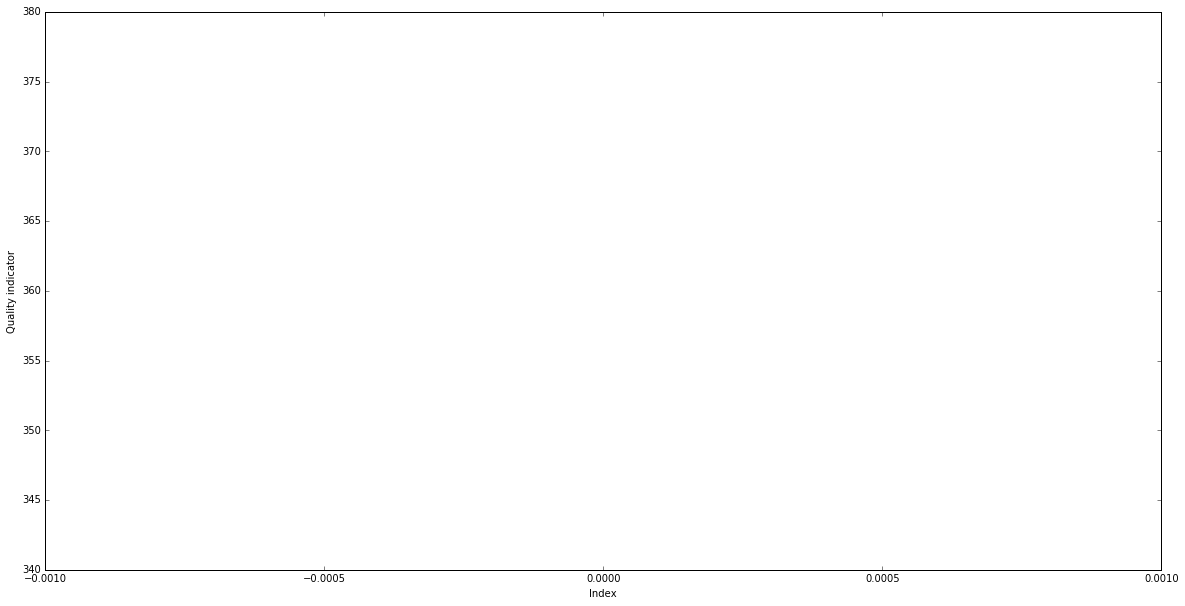

In [84]:
# Here we define the working directory from where the summary files will be taken:
workdir = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output'
# res will contain the list of (index, scores), sorted increasingly on the score
# The number is the total number of files
res = run_analysis(workdir, 1, 1)

For moving the $n$ best to a new folder:

In [67]:
fol = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output_post'
newFol = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output_post_50'
n = 50
move_best_n_summaries(fol, newFol, [a[0] for a in res[-n:]])

**After running Section 3.2 from this notebook:**

For moving the $n$ best to a new folder according to the `Quality_indicator` **plus** the $n$ best according to the `2nd_Classifier`:

In [45]:
fol = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output_micro_6_post'
n = 10
os.chdir(fol)
df = pd.read_excel('Final_results.xlsx')
score = list(df.index[-n:].copy())
df2 =  pd.DataFrame(data=df.sort_values('2nd_Classifier', ascending=False))
score2 = list(df2.index[-n:].copy())
set1 = set(score)
set2 = set(score2)
score_comb = set1.union(set2)
print('Total number of summary files that will be copied: %i.' % len(score_comb))
print('The ones that were in both top %is are: %s.' % (n, set1.intersection(set2)))

Total number of summary files that will be copied: 20.
The ones that were in both top 10s are: set().


In [46]:
fol = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output_micro_6_post'
newFol = 'Real_cars_output_' + str(n) + '+' + str(n)
move_best_n_summaries(fol, newFol, [a for a in score_comb])

## Parallel plot generation

### Parallel plot code

This section contains the testing and developement of code for producing a parallel coordinates plot:

https://en.wikipedia.org/wiki/Parallel_coordinates

http://stackoverflow.com/questions/8230638/parallel-coordinates-plot-in-matplotlib

http://pandas.pydata.org/pandas-docs/stable/visualization.html#parallel-coordinates

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def parallel_coordinates(data_sets, tags=None, style=None, dots=None):

    dims = len(data_sets[0])
    x    = range(dims)
    fig, axes = plt.subplots(1, dims-1, sharey=False, figsize=(20,10))
    
    if tags is None:
        tags = ['a_' + str(i) for i in range(dims)]
    
    if style is None:
        style = ['r-'] * len(data_sets)

    # Add dots to the top 25% values of the dataset:
    if dots is None:
        dots = int(np.ceil(len(data_sets[0]) * 0.25))
    
    # Calculate the limits on the data
    min_max_range = list()
    for m in zip(*data_sets):
        mn = min(m)
        mx = max(m)
        if mn == mx:
            mn -= 0.5
            mx = mn + 1.
        r  = float(mx - mn)
        min_max_range.append((mn, mx, r))

    # Normalize the data sets
    norm_data_sets = list()
    for ds in data_sets:
        nds = [(value - min_max_range[dimension][0]) / 
                min_max_range[dimension][2] 
                for dimension,value in enumerate(ds)]
        norm_data_sets.append(nds)
    data_sets = norm_data_sets

    # Plot the datasets on all the subplots
    top_ds = data_sets[len(data_sets)-dots:]
    for i, ax in enumerate(axes):
        for dsi, d in enumerate(data_sets):
            ax.set_xlabel(tags[i])    
            ax.xaxis.set_label_coords(0, -0.05)
            ax.plot(x, d, color=str(style[dsi]))
        for dsi, d in enumerate(top_ds):
            ax.plot(x, d, color='green', marker='o', linestyle='None', markersize=10)
        ax.set_xlim([x[i], x[i+1]])
    axes[dims-2].text(dims-1, -0.065, tags[dims-1])

    # Set the x axis ticks 
    for dimension, (axx,xx) in enumerate(zip(axes, x[:-1])):
        axx.xaxis.set_major_locator(ticker.FixedLocator([xx]))
        ticks = len(axx.get_yticklabels())
        labels = list()
        step = min_max_range[dimension][2] / (ticks - 1)
        mn   = min_max_range[dimension][0]
        for i in range(ticks):
            v = mn + i*step
            labels.append('%4.2f' % v)
        axx.set_yticklabels(labels)


    # Move the final axis' ticks to the right-hand side
    axx = plt.twinx(axes[-1])
    dimension += 1
    axx.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    ticks = len(axx.get_yticklabels())
    step = min_max_range[dimension][2] / (ticks - 1)
    mn   = min_max_range[dimension][0]
    labels = ['%4.2f' % (mn + i*step) for i in range(ticks)]
    axx.set_yticklabels(labels)
                
            
    # Stack the subplots 
    plt.subplots_adjust(wspace=0)

    return plt

### Statistics an putting everything together

Put scores, inputs and statistics together:

In [55]:
import re
from ast import literal_eval as make_tuple
from IPython.display import display

def combine_data(workdir, inputs, sheet, input_labels, n, m, excluded=None):
    """
    Combine scores, parameter combinations and statistics in an adequate structure to produce the parallel coordinates plot.
    
    Parameters
    ----------
    workdir : Path to the working directory where the summary files and the scores are.
    inputs : Path to excel file where the parameter combination is.
    sheet : Name of the sheet of the excel file with the parameter combination.
    input_labels : List with the names of the parameters.
    n : Number of summary files considered.
    m : Number of summary files that will be highlighted in the plot: best m of them.
    excluded : List of indexes of parameters combinations to exclude in the run, if any.
    """

    # When we run before the code from Victor, a `txt` with the total scores is produced. Here we retrieve this values **as a tuple of strings**:
    pattern = re.compile("Final quality indicator of the run is: (\d{2,5})(\.)*(\d{0,2})")
    results = []
    for i, line in enumerate(open(workdir + '/Analysis_results.txt')):
        for match in re.finditer(pattern, line):
            #print('Found on line %s: %s' % (i+1, match.groups()))
            results.append(match.groups())
    # Convert scores to floats:
    results_float = []
    for val in results:
        results_float.append(float(val[0]) + float(val[2]) * 10**(-len(val[2])))     

    # Get some statistics from every batch:
    # · run time
    # · mean(error)
    # · mean(abs(error))
    # · stdDev(error)
    # · min(error)
    # · max(error)
    # · range(error)
    # · avg(num perturbations)
    # · min(num perturbations)
    # · max(num perturbations)
    os.chdir(workdir)
    index, elapsed, meanError, meanAbsError, stdError, minim, maxim, rang, meanPer, minPer, maxPer = [], [], [], [], [], [], [], [], [], [], []
    idx = pd.IndexSlice
    for file in glob.glob("*summary.xlsx"):
        # Save the index of the parameter combination
        index.append(int(file[3:7]))
        # Second sheet of the Excel
        proc_info = pd.read_excel(file, 'proc_info')
        elapsed.append(float(proc_info['Value'][2].split()[0]))
        # First sheet of the Excel
        summary = pd.read_excel(file, 'summary', header=[0, 1, 2, 3], index_col=[0], skiprows=[4])
        out = np.array(summary.loc[:, idx['nedc_h', 'prediction', 'output', 'value']])[:-1]
        tar = np.array(summary['nedc_h', 'prediction', 'target'][['value', 'declared_value']].max(axis=1))[:-1]
        per = np.array(summary.loc[:, idx['wltp_h', 'calibration', 'output', 'rescaling_n']])[:-1]
        error = (out - tar) / tar
        meanError.append(np.mean(error))
        meanAbsError.append(np.mean(np.abs(error)))
        stdError.append(np.std(error, ddof=1)) #<-- Check np.std docs for the meaning of ddof
        minim.append(np.min(error))
        maxim.append(np.max(error))
        rang.append(maxim[-1] - minim[-1])
        meanPer.append(np.mean(per))
        minPer.append(np.min(per))
        maxPer.append(np.max(per))
    
    # Compute the 2nd classifier, defined by Giorgos:
    secClass = [(meanPer[i]/np.min(meanPer) + stdError[i]/np.min(stdError) + np.abs(meanError[i]) + rang[i]/np.min(rang) + np.abs(minim[i]) - 3)
                for i in range(n)]

    # Put all this additional information together
    addInfo = pd.DataFrame(data = list(map(list, zip(*[elapsed, meanError, meanAbsError, stdError, minim, maxim, rang, meanPer, minPer, maxPer, secClass]))), 
                           columns=['Elapsed_time', 'mean(error)', 'mean(abs(error))', 'std(error)', 'min(error)', 'max(error)', 'range(error)', 'mean(perturbations)', 'min(perturbations)', 'max(perturbations)', '2nd_Classifier'],
                           index=index)
    
    # Combine scores, inputs and statistics:
    inputs = pd.read_excel(inputs, sheet)
    # Remove the excluded ones ONLY IF NECCESARY!!!
    if excluded is not None:
        inputs.drop(inputs.index[excluded], inplace=True)
    #------------------------------------------------------------------------------
    # Small code for separating in the input a 2-tuple into two values for the plot (comment the next line if it is not neccesary)
    inputs = inputs[inputs.columns[0:7]].join(pd.DataFrame(list(map(lambda x: make_tuple(x), inputs[inputs.columns[7]])), index=index).join(inputs[inputs.columns[8]]))
    #------------------------------------------------------------------------------
    inputs.columns = input_labels
    inputs.index = index
    outputs = pd.DataFrame(data=results_float, columns=['Quality_indicator'], index=index)
    combined = outputs.join(inputs).join(addInfo[addInfo.columns[0]])
    combined_sorted = pd.DataFrame(data=combined.sort_values('Quality_indicator', ascending=True))
    
    # The m first ones will be highlighted in the plot (in red):
    # E50000 => RED
    # ADD8E6 => LIGHT BLUE
    colors = ['#ADD8E6' if (i < n - m) else '#E50000' for i in range(n)]
    # Note that in the plot we don't include the statistics since it would be too much information
    labels = ['Quality'] + [lab for lab in input_labels] + ['Elapsed_time']
    plot_all_colored = parallel_coordinates(combined_sorted.as_matrix(), tags=labels, style=colors, dots=0)
    plot_all_colored.show()
    
    # We save in an excel the whole dataframe with statistics, and we return it:
    combined_full = outputs.join(inputs).join(addInfo)
    combined_full_sorted = pd.DataFrame(data=combined_full.sort_values('Quality_indicator', ascending=True))
    combined_full_sorted.to_excel('./Final_results.xlsx')
    return combined_full_sorted

$$2^{nd} classifier_i = \frac{mean(perturbations_i)}{min(mean(perturbations))} + \frac{std(error_i)}{min(std(error))} + |mean(error_i)| + \frac{range(error_i)}{min(range(error))} + |min(error_i)| - 3,\quad \forall\ i \in [0, numSummaries]$$

### The call to the main function

In [85]:
# Final call to produce the plot and the resulting dataframe
workdir = r'D:\Work\Jupyter Notebooks\ipyparallel-notebooks\Real_cars_output'
par_comb = '../Parameter_combination_micro.xlsx'
sheet = 'Sheet1'
#input_labels = ['a', 'b', 'gbp00_m', 'gbp00_q', 'gbp10_m', 'gbp10_q', 'gbp01_q', 'torque_loss_m', 'torque_loss_q', 'power_loss']
input_labels = ['torque_loss_m', 'torque_loss_q', 'power_loss']
excluded = [exc for exc in range(125) if exc not in score_comb]
#excluded = [2, 13]
results = combine_data(workdir, par_comb, sheet, input_labels, 1, 1)

D:\Apps\co2mpas_AIO-v1.5.5\Apps\WinPython\python-3.5.2.amd64\lib\site-packages\ipykernel\ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


# Offtopic: Things related to the parallel coordinates plot and other stuff

Example of a parallel coordinate plot using the above algorithm with random numbers:

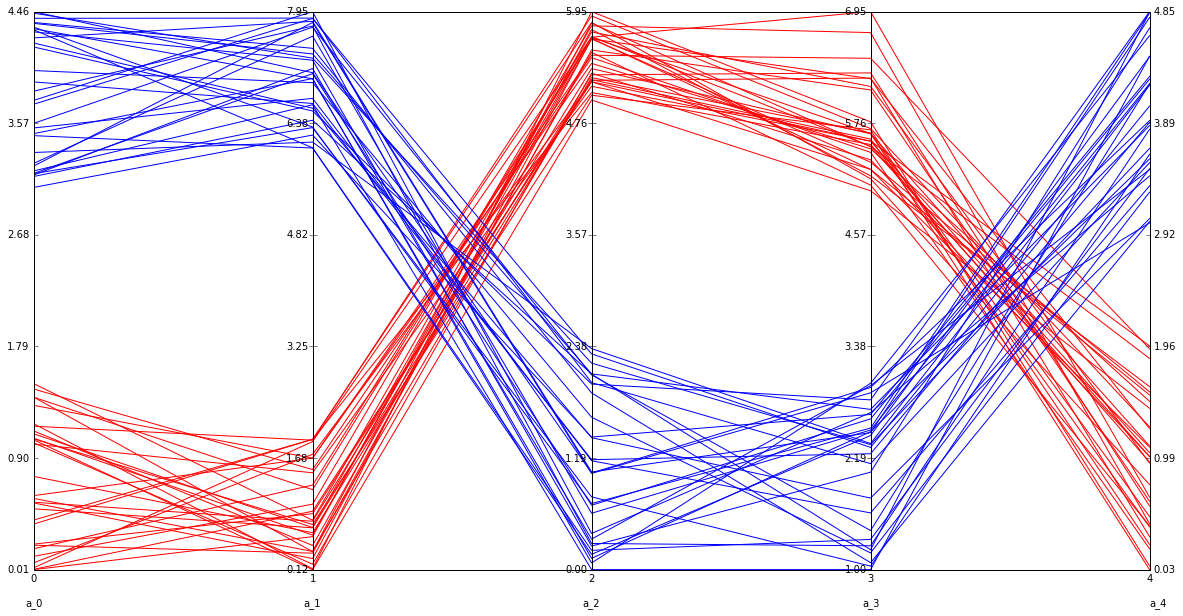

In [234]:
import random
base  = [0,   0,  5,   5,  0]
scale = [1.5, 2., 1.0, 2., 2.]
data = [[base[x] + random.uniform(0., 1.)*scale[x]
        for x in range(5)] for y in range(30)]
colors = ['r'] * 30
base  = [3,   6,  0,   1,  3]
scale = [1.5, 2., 2.5, 2., 2.]
data.extend([[base[x] + random.uniform(0., 1.)*scale[x]
             for x in range(5)] for y in range(30)])
colors.extend(['b'] * 30)
parallel_coordinates(data, style=colors).show()

Pandas already has a built-in function for this kind of plots, but unfortunately we cannot use it because **the range of each of our parameters is different!**

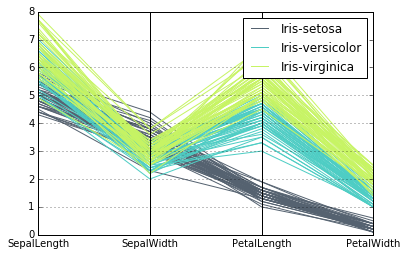

In [20]:
from pandas import read_csv
from pandas.tools.plotting import parallel_coordinates
from matplotlib import pyplot as plt
df = read_csv('https://raw.github.com/pandas-dev/pandas/master'
                    '/pandas/tests/data/iris.csv')
parallel_coordinates(df, 'Name', color=('#556270',
                         '#4ECDC4', '#C7F464'))
plt.show()

Modify _UDC, EUDC and NEDC_ (on the summary files) times 1.005 for the second launch:

In [318]:
os.chdir(workdir)
idx = pd.IndexSlice
for file in glob.glob("*summary.xlsx"):
    summary = pd.read_excel(file, 'summary', header=[0, 1, 2, 3], index_col=[0], skiprows=[4])
    proc_info = pd.read_excel(file, 'proc_info')
    summary.loc[:, idx['nedc_h', 'prediction', 'output', 'UDC']] *= 1.005
    summary.loc[:, idx['nedc_h', 'prediction', 'output', 'EUDC']] *= 1.005
    summary.loc[:, idx['nedc_h', 'prediction', 'output', 'value']] *= 1.005
    writer = pd.ExcelWriter('../Real_cars_output_1_005/' + file)
    summary.to_excel(writer, 'summary')
    proc_info.to_excel(writer, 'proc_info')
    writer.save()

# Next section

In [86]:
os.chdir('..')

In [50]:
list(np.linspace(0, 0.3333, 5))

[0.0, 0.083324999999999996, 0.16664999999999999, 0.249975, 0.33329999999999999]

In [53]:
num = 5
dat = []
for i in np.linspace(0, 0.3333, num):
    for j in np.linspace(0, 1, num):
        for k in np.linspace(0, 0.1, num):
            dat.append([(i, j), k])
params = pd.DataFrame(data=dat)
params.to_excel('Parameter_combination_micro.xlsx')

In [54]:
params

,0,1
0,"(0.0, 0.0)",0.000
1,"(0.0, 0.0)",0.025
2,"(0.0, 0.0)",0.050
3,"(0.0, 0.0)",0.075
4,"(0.0, 0.0)",0.100
5,"(0.0, 0.25)",0.000
6,"(0.0, 0.25)",0.025
7,"(0.0, 0.25)",0.050
8,"(0.0, 0.25)",0.075
9,"(0.0, 0.25)",0.100
